In [18]:
from collections import Counter
import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T

from model import SAT
from util import CocoCaptionDataset

In [2]:
checkpoint_path = "logs/default/version_30/last.ckpt"

workers = 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SAT.load_from_checkpoint(checkpoint_path, map_location=device).to(device)
model.eval()
model.freeze()

valid_transforms = T.Compose([
    T.Resize(model.hparams.input_size),
    T.CenterCrop(model.hparams.input_size),
    T.ToTensor()
])
valid_ds = CocoCaptionDataset(jsonpath=model.hparams.json, split="test", transforms=valid_transforms)
val_loader = DataLoader(dataset=valid_ds, batch_size=model.hparams.batch, num_workers=workers,
                        persistent_workers=(True if workers > 0 else False), pin_memory=True)

In [3]:
headers = ["beamk", "temperature", "rescore_method", "rescore_reward", "bleu1", "bleu2", "bleu3", "bleu4", "gleu", "cosine_similarity", "perplexity"]
results = pd.DataFrame(columns=headers)

In [116]:
beamks = [3, 40]  # log sampling
temperatures = [0.7, 1.1]  # uniform sampling
methods = ["NONE", "LN", "WR", "BAR"]  # random Choice
# WR reward increase with beam
# BAR >1.0 is best for most beam
rewards = [0.5, 2.2]  # uniform sampling
iterations = 50  # Number of times to run the evaluation

In [119]:
# random grid search for N trials
for n_iter in range(iterations):
    print(f"Start Iteration {n_iter+1} of {iterations}")

    # Sample the captioning parameters
    # beamk = int(10**np.random.uniform(np.log10(beamks[0]), np.log10(beamks[1])))
    beamk = int(np.random.uniform(beamks[0], beamks[1]))
    temperature = np.random.uniform(temperatures[0], temperatures[1])
    method = np.random.choice(methods)
    reward = np.random.uniform(rewards[0], rewards[1])
    print(f"{beamk=}. {temperature=:.2f}. {method=}. {reward=:.2f}")

    row = {"beamk": beamk, "temperature": temperature, "rescore_method": method, "rescore_reward": reward}

    t0 = time.time()
    batch_metrics_total = Counter({})
    for batch_idx, batch in enumerate(val_loader):
        batch = [x.to(device) for x in batch]
        metrics = model.val_batch(batch, beamk=beamk, max_gen_length=32, temperature=temperature, rescore_method=method, rescore_reward=reward)
        batch_metrics_total += Counter(metrics)

        duration = time.time()-t0
        avg_duration = duration/(batch_idx+1)
        print(f"\rBatch {batch_idx+1}. Duration: {duration:.2f}s. Average Batch Time: {avg_duration:.2f}s.", end="")
        # if batch_idx+1>=2: break

    batch_metrics_avg = {k: v/(batch_idx+1) for k, v in batch_metrics_total.items()}
    row.update(batch_metrics_avg)
    results = results.append(row, ignore_index=True)

    print(f"\nFinish Iteration {n_iter+1} of {iterations}")

print("Done.")

Start Iteration 1 of 50
beamk=3. temperature=1.26. method='BAR'. reward=1.19
Batch 12. Duration: 32.12s. Average Batch Time: 2.68s.
Finish Iteration 1 of 50
Start Iteration 2 of 50
beamk=34. temperature=1.25. method='LN'. reward=0.85
Batch 12. Duration: 89.68s. Average Batch Time: 7.47s.
Finish Iteration 2 of 50
Start Iteration 3 of 50
beamk=12. temperature=1.03. method='LN'. reward=0.34
Batch 12. Duration: 47.38s. Average Batch Time: 3.95s.
Finish Iteration 3 of 50
Start Iteration 4 of 50
beamk=10. temperature=0.50. method='BAR'. reward=0.74
Batch 12. Duration: 44.89s. Average Batch Time: 3.74s.
Finish Iteration 4 of 50
Start Iteration 5 of 50
beamk=31. temperature=0.63. method='WR'. reward=1.06
Batch 12. Duration: 83.34s. Average Batch Time: 6.95s.
Finish Iteration 5 of 50
Start Iteration 6 of 50
beamk=16. temperature=1.23. method='NONE'. reward=0.43
Batch 12. Duration: 54.19s. Average Batch Time: 4.52s.
Finish Iteration 6 of 50
Start Iteration 7 of 50
beamk=13. temperature=0.59. met

KeyboardInterrupt: 

In [120]:
results.sort_values(by="bleu4", ascending=False)

,beamk,temperature,rescore_method,rescore_reward,bleu1,bleu2,bleu3,bleu4,gleu,cosine_similarity,perplexity
65,13.0,0.853142,WR,0.918236,0.605936,0.420090,0.292214,0.200540,0.210576,0.620151,1.743284
56,15.0,0.867110,LN,1.336447,0.602330,0.418129,0.290388,0.198913,0.209168,0.617898,1.758567
78,16.0,0.830560,LN,0.860635,0.602226,0.417087,0.289386,0.198239,0.209110,0.618565,1.705930
51,32.0,0.995753,WR,1.899147,0.605687,0.415937,0.288486,0.198035,0.212935,0.618253,2.057043
18,13.0,1.150887,WR,1.202058,0.602946,0.416844,0.289021,0.197949,0.209774,0.615720,2.305867
...,...,...,...,...,...,...,...,...,...,...,...
80,23.0,1.265721,NONE,1.253760,0.570635,0.391244,0.266552,0.177486,0.195054,0.594820,2.678995
24,16.0,0.291254,BAR,0.530146,0.585625,0.398138,0.267966,0.177244,0.196505,0.608940,1.183272
10,3.0,0.254989,BAR,0.759171,0.587074,0.398131,0.267633,0.176916,0.196329,0.609515,1.157504
13,6.0,1.660498,NONE,1.852624,0.572806,0.389061,0.264826,0.175199,0.192598,0.592534,4.707281


In [121]:
results.columns

Index(['beamk', 'temperature', 'rescore_method', 'rescore_reward', 'bleu1',
       'bleu2', 'bleu3', 'bleu4', 'gleu', 'cosine_similarity', 'perplexity'],
      dtype='object')

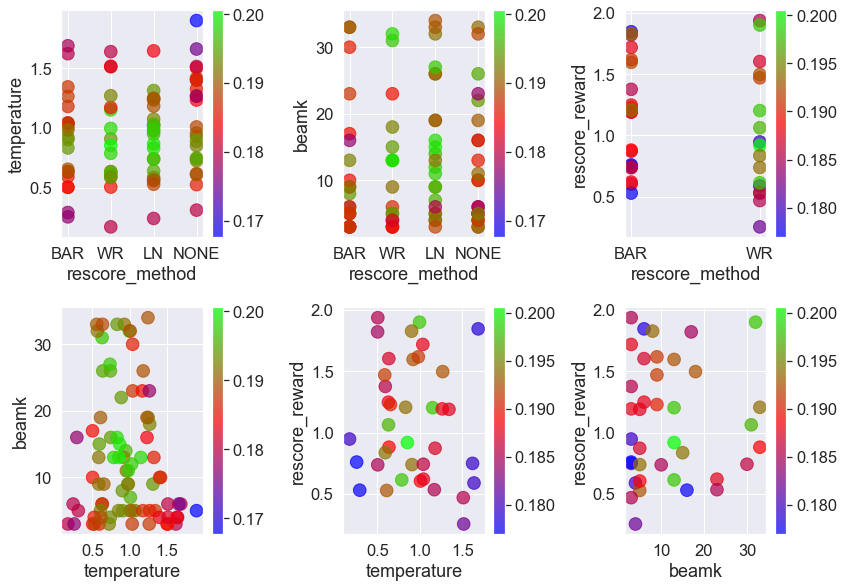

In [125]:
scale = 4
size = 40
color = "bleu4"
plots = [ # x, y, color
    ["rescore_method", "temperature", color],
    ["rescore_method", "beamk", color],
    ["rescore_method", "rescore_reward", color],
    ["temperature", "beamk", color],
    ["temperature", "rescore_reward", color],
    ["beamk", "rescore_reward", color],
]
rr = int(np.ceil(np.sqrt(len(plots)))) 
fig = plt.figure(figsize=[scale*rr, scale*rr])
for i, (x, y, c) in enumerate(plots):
    fig.add_subplot(rr, rr, i+1)
    ax = plt.gca()

    if "rescore_reward" in [x, y]:
        # Remove the
        subset = results[(results["rescore_method"]!="NONE")&(results["rescore_method"]!="LN")]
    else:
        subset = results

    im = ax.scatter(
        x=subset[x], y=subset[y],
        s=size*scale, alpha=0.7,
        c=subset[c], cmap="brg",
    )
    fig.colorbar(im, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
fig.tight_layout()

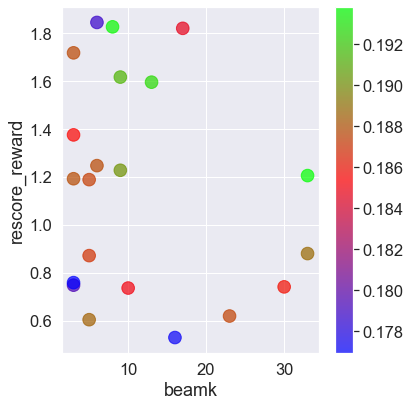

In [139]:
fig = plt.figure(figsize=[6, 6])
ax = plt.gca()
subset = results[results["rescore_method"]=="BAR"]
# beamk, temperature, rescore_reward
x = "beamk"
y = "rescore_reward"
c = "bleu4"
im = ax.scatter(
    x=subset[x], y=subset[y],
    s=size*scale, alpha=0.7,
    c=subset[c], cmap="brg",
)
fig.colorbar(im, ax=ax)
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.tight_layout()

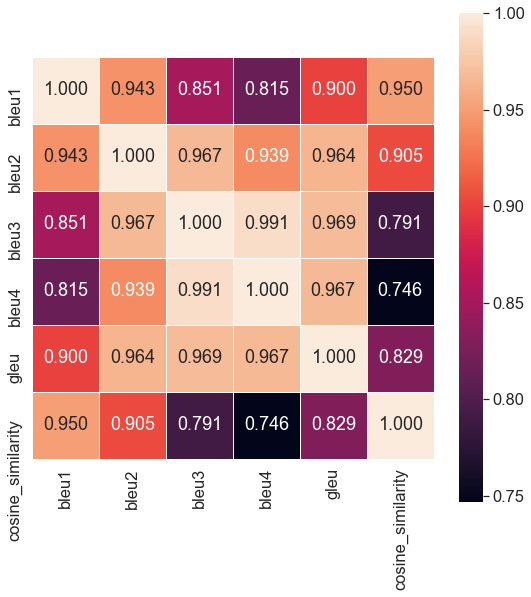

In [124]:
scale = 1.5
cols = ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'gleu', 'cosine_similarity']
data = results[cols].corr(method='pearson')
fig = plt.figure(figsize=(scale*len(cols), scale*len(cols)))
sn.set(font_scale=scale)  # Label size
ax = sn.heatmap(data,
    annot=True, fmt=".3f", annot_kws={"size": scale*12},
    # cmap='Blues',
    # vmin=0, vmax=1,
    xticklabels=cols,  yticklabels=cols,
    square=True, linewidths=0.5)